<a href="https://colab.research.google.com/github/gtsagkatakis/Data-Science-and-Applications/blob/main/CSD458_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CSD458 HW5**
Classify Fashion MNist images using CNNs

In [2]:
# Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms



### **PART A: Training Convolutional Neural Networks (CNNs)**



#### 1. Download the Fashion Mnist Dataset



In [ ]:
# Define the transformation to convert PIL images to tensors
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download the training data
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                             download=True, transform=transform)

# Download the test data
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                            download=True, transform=transform)


#### 2. Define the Dataset, Dataloader, Transforms. Use v2.Compose() to include even more transforms, such as rotations, crops and others.



In [68]:
# Define the dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### 3. Make your own version of CNN and report the validatation set accuracy



In [226]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def create_layer(in_channels, out_channels, kernel_size=3, stride=1, padding=1, pool_kernel_size=2, pool_stride=2, include_pooling=True):
    """
    Creates a layer consisting of two convolutional blocks followed by a max pooling operation.
    Each block consists of a Convolution -> ReLU sequence. This is followed by Batch Normalization and Max Pooling.
    """
    layer = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels)
    )
    
    if include_pooling:
        layer.add_module('MaxPool', nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride))
    
    return layer

class ParametrizedCNN(nn.Module):
    def __init__(self, in_channels, first_out_channels, n_layers=2):
        super(ParametrizedCNN, self).__init__()

        # Initial in_channels is 1 for grayscale images
        self.initial_in_channels = in_channels
        self.initial_out_channels = first_out_channels
        self.n_layers = n_layers
        

        # self.layer1 = create_layer(self.initial_in_channels, self.initial_out_channels)
        # self.layer2 = create_layer(self.initial_out_channels, self.initial_out_channels * 2)
        # self.layer3 = create_layer(self.initial_out_channels * 2, self.initial_out_channels * 4)
        
        # Create the layers
        self.layers = nn.ModuleList([create_layer(self.initial_in_channels, self.initial_out_channels)])
        for i in range(1, n_layers):
            if i == n_layers - 1:
                self.layers.append(create_layer(self.initial_out_channels * (2 ** (i - 1)), self.initial_out_channels * (2 ** i), include_pooling=False))
            else:
                self.layers.append(create_layer(self.initial_out_channels * (2 ** (i - 1)), self.initial_out_channels * (2 ** i)))
        
        self.fc1 = nn.Linear(self.initial_out_channels * (2 ** (self.n_layers - 1)), 10)  # Assuming final output has 10 classes

    def forward(self, x):
        # x = self.layer1(x)
        # x = self.layer2(x)
        # x = self.layer3(x)
        
        # Apply the layers
        for layer in self.layers:
            x = layer(x)
        
        # Apply Global Average Pooling, instead of flattening and big fully connected layers
        x = F.adaptive_avg_pool2d(x, (1, 1))
        
        x = x.view(-1, self.initial_out_channels * (2 ** (self.n_layers - 1)))  # Flatten for the fully connected layer;

        x = self.fc1(x)

        # Return log softmax of the output
        return F.log_softmax(x, dim=1)


In [97]:
import torch.optim as optim
import csv

# Prepare to save results
results_filename = "_hyperparameter_search_results.csv"
fields = ['Filter Size', 'Learning Rate', 'Epoch', 'Training Loss', 'Test Loss', 'Accuracy']

with open(results_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(fields)  # Write the header

# Lists of hyperparameters to try
initial_filter_sizes = [16, 32, 64]
learning_rates = [0.001, 0.003, 0.005]

n_epochs = 10

for filter_size in initial_filter_sizes:
    for lr in learning_rates:
        print(f"\nTraining with initial filter size: {filter_size}, learning rate: {lr}")

        # Initialize model, loss function, and optimizer with current hyperparameters
        model = ParametrizedCNN(1, filter_size).to(device)  # Use current filter size
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)  # Use current learning rate

        for epoch in range(n_epochs):
            model.train()  # Set the model to training mode
            train_loss = 0.0

            # Training phase
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            average_train_loss = train_loss / len(trainloader)

            # Evaluation phase
            model.eval()  # Set the model to evaluation mode
            test_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            average_test_loss = test_loss / len(testloader)
            accuracy = 100 * correct / total

            print(f'Epoch {epoch+1}, Training Loss: {average_train_loss:.4f}, Test Loss: {average_test_loss:.4f}, Accuracy: {accuracy:.2f}%')

            # Save results to the CSV file
            with open(results_filename, mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([filter_size, lr, epoch+1, average_train_loss, average_test_loss, accuracy])

        # Log the summary for this set of hyperparameters
        print(f"Completed Training with filter size {filter_size}, lr {lr}: Test Loss: {average_test_loss:.4f}, Accuracy: {accuracy:.2f}%")
        print("-" * 50)

print(f"Results have been saved to {results_filename}")



Training with initial filter size: 16, learning rate: 0.001
Epoch 1, Training Loss: 0.4039, Test Loss: 0.3269, Accuracy: 88.21%
Epoch 2, Training Loss: 0.2572, Test Loss: 0.2672, Accuracy: 90.51%
Epoch 3, Training Loss: 0.2183, Test Loss: 0.2831, Accuracy: 89.82%
Epoch 4, Training Loss: 0.1953, Test Loss: 0.2548, Accuracy: 90.65%
Epoch 5, Training Loss: 0.1765, Test Loss: 0.2516, Accuracy: 91.31%
Epoch 6, Training Loss: 0.1614, Test Loss: 0.2312, Accuracy: 91.94%
Epoch 7, Training Loss: 0.1464, Test Loss: 0.2335, Accuracy: 91.90%
Epoch 8, Training Loss: 0.1315, Test Loss: 0.2276, Accuracy: 92.02%
Epoch 9, Training Loss: 0.1199, Test Loss: 0.2354, Accuracy: 92.02%
Epoch 10, Training Loss: 0.1058, Test Loss: 0.2446, Accuracy: 92.17%
Completed Training with filter size 16, lr 0.001: Test Loss: 0.2446, Accuracy: 92.17%
--------------------------------------------------

Training with initial filter size: 16, learning rate: 0.003
Epoch 1, Training Loss: 0.3803, Test Loss: 0.3039, Accuracy:

In [104]:
import pandas as pd
# Load the CSV file to analyze the hyperparameter search results
df = pd.read_csv('hyperparameter_search_results.csv')

,Filter Size,Learning Rate,Epoch,Training Loss,Test Loss,Accuracy
0,16,0.001,1,0.403881,0.326912,88.21
1,16,0.001,2,0.257223,0.267213,90.51
2,16,0.001,3,0.218314,0.283108,89.82
3,16,0.001,4,0.195282,0.254776,90.65
4,16,0.001,5,0.176455,0.251561,91.31


C:\Users\nikba\anaconda3\envs\python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nikba\anaconda3\envs\python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nikba\anaconda3\envs\python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\nikba\anaconda3\envs\python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When groupi

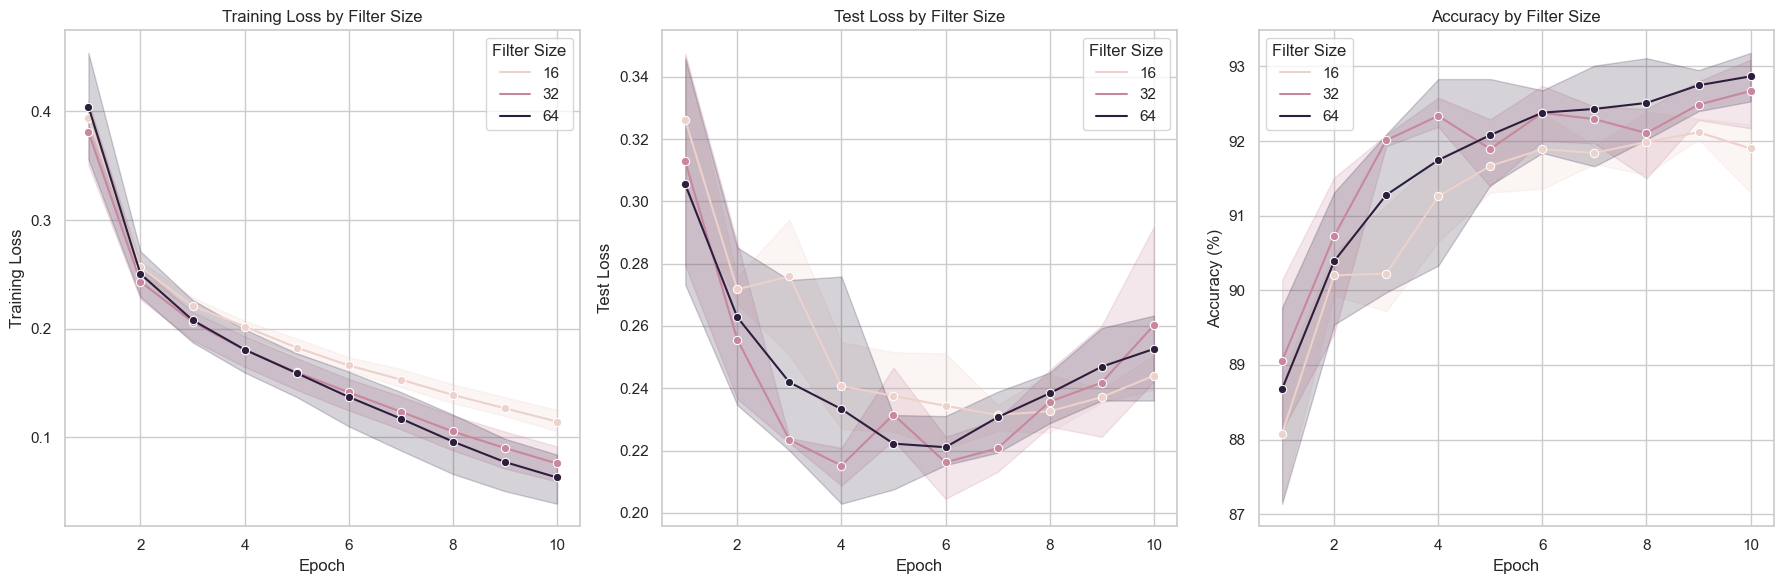

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Plot settings
plt.figure(figsize=(18, 6))

# Plot for Training Loss
plt.subplot(1, 3, 1)
sns.lineplot(data=df, x="Epoch", y="Training Loss", hue="Filter Size", marker="o")
plt.title('Training Loss by Filter Size')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(title='Filter Size')

# Plot for Test Loss
plt.subplot(1, 3, 2)
sns.lineplot(data=df, x="Epoch", y="Test Loss", hue="Filter Size", marker="o")
plt.title('Test Loss by Filter Size')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.legend(title='Filter Size')

# Plot for Accuracy
plt.subplot(1, 3, 3)
sns.lineplot(data=df, x="Epoch", y="Accuracy", hue="Filter Size", marker="o")
plt.title('Accuracy by Filter Size')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(title='Filter Size')

plt.tight_layout()
plt.show()


We observe clear signs of overfitting after epoch 6. The training loss keeps decreasing, while the test loss starts increasing. 

Let's try data augmentation and L2 Regularization to see if we can improve the model's performance, by introducing variance to the training samples, thus in theory training a model that will be able to generalize to unseen data better.

In [227]:
# Define the transformation to convert PIL images to tensors
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomRotation(20),
                                transforms.RandomHorizontalFlip(),
                                transforms.Normalize((0.5,), (0.5,))])

# process the training data
trainset = torchvision.datasets.FashionMNIST(root='./data_augm', train=True,
                                            transform=transform)


# transformation for the test data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# process the test data
testset = torchvision.datasets.FashionMNIST(root='./data_augm', train=False,
                                            transform=transform)

# Define the dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                            shuffle=False, num_workers=2)


In [231]:
# Instantiate the model
model = ParametrizedCNN(1, 32, 3).to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
print(model)

ParametrizedCNN(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3,

In [232]:
# print total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')

288,170 total parameters.


In [230]:
# Train and evaluate the model
n_epochs = 15

for epoch in range(n_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    # Training phase
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluation phase
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}, Train Loss:{train_loss/len(trainloader):.4f} Test Loss:{test_loss /len(testloader):.4f} Accuracy: {accuracy}%')


KeyboardInterrupt: 

#### 5. Increase the number of Layers of the CNN (the number of convolutions followed by pooling layers) and observe what happens, in terms of the progress of the training and validation losses and the final model accuracies.



#### 6. Visualize some of the Feature Maps and Convolution Kernels that you find interesting.

### **PART B: Transfer Learning**







#### 1. Load a Pretrained model (the simpler the better for computational efficiency e.g.resnet16). You are gonna use it to train your model on Fashion Mnist

#### 2. Freeze the BackBone of the pretrained model (Convolutions etc) and modify the final fully connected layer/layers that perform classification (make sure the new output dimension matches the number of classes in Fashion Mnist)

#### 3. Train the model on Fashion Mnist for a few epoches and log your train/val loss progress as well as the final model accuracy on the validation set.

#### **Optional:** If you are interested you can also unfreeze the final convolutions of the pretrained model to Fine Tune it. You can even visualize the Feature Maps of you model.

#### *Guidelines*: The goal of this assignment is that you play around a little bit with terms and notions introduced. You don' t have to train your models for ages. 5-10 epoches will suffice. We just want to see that you can make a model properly, train it and log some results.